In [19]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import json
from model_training_process import *
import requests
import matplotlib.pyplot as plt
import os

In [20]:
class_df = pd.read_csv("..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df[["pinyin", "class_label"]]

,pinyin,class_label
0,zhi,0
1,chi,0
2,shi,0
3,ri,0
4,zi,1
...,...,...
402,xun,20
403,yong,18
404,jiong,20
405,qiong,20


In [21]:
class_df['class_label_index'] = class_df.groupby('class_label').cumcount()
class_df[["pinyin", "class_label", "class_label_index"]]

,pinyin,class_label,class_label_index
0,zhi,0,0
1,chi,0,1
2,shi,0,2
3,ri,0,3
4,zi,1,0
...,...,...,...
402,xun,20,11
403,yong,18,4
404,jiong,20,12
405,qiong,20,13


In [22]:
npy_file_path_list = glob("..\\..\\data\\*EduVer\\*")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")

len(npy_file_path_list): 67173


In [23]:
selected_npy_file_path_list = list()
for npy_file_path in npy_file_path_list:
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        selected_npy_file_path_list.append(npy_file_path)
print(f"len(npy_file_path_selected): {len(selected_npy_file_path_list)}")

len(npy_file_path_selected): 66852


In [24]:
print(len(class_df.groupby("class_label").count().index))
class_df.groupby("class_label").count().index

21


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='class_label')

In [25]:
dic = dict()

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = list()
    dic[f"class_{i}_class_label_index_list"] = list()

for npy_file_path in tqdm(selected_npy_file_path_list):
    pinyin = npy_file_path.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin

    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].values[0]
    class_label_index = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label_index"].values[0]
    # print(f"{pinyin_non_accent}, {class_label}, {class_label_index}")

    mfcc_matrix = np.load(npy_file_path)
    dic[f"class_{class_label}_mfcc_matrix_list"].append(mfcc_matrix)
    dic[f"class_{class_label}_class_label_index_list"].append(class_label_index)

for i in range(len(class_df.groupby("class_label").count().index)):
    dic[f"class_{i}_mfcc_matrix_list"] = np.array(dic[f"class_{i}_mfcc_matrix_list"])
    dic[f"class_{i}_class_label_index_list"] = np.array(dic[f"class_{i}_class_label_index_list"])

for i in range(len(class_df.groupby("class_label").count().index)):
    print(f"class_{i}_mfcc_matrix_list.shape: {dic[f'class_{i}_mfcc_matrix_list'].shape}")
    print(f"class_{i}_class_label_index_list.shape: {dic[f'class_{i}_class_label_index_list'].shape}")

100%|██████████| 66852/66852 [00:26<00:00, 2531.87it/s]


class_0_mfcc_matrix_list.shape: (3133, 13, 44)
class_0_class_label_index_list.shape: (3133,)
class_1_mfcc_matrix_list.shape: (844, 13, 44)
class_1_class_label_index_list.shape: (844,)
class_2_mfcc_matrix_list.shape: (1322, 13, 44)
class_2_class_label_index_list.shape: (1322,)
class_3_mfcc_matrix_list.shape: (5333, 13, 44)
class_3_class_label_index_list.shape: (5333,)
class_4_mfcc_matrix_list.shape: (7255, 13, 44)
class_4_class_label_index_list.shape: (7255,)
class_5_mfcc_matrix_list.shape: (4499, 13, 44)
class_5_class_label_index_list.shape: (4499,)
class_6_mfcc_matrix_list.shape: (6060, 13, 44)
class_6_class_label_index_list.shape: (6060,)
class_7_mfcc_matrix_list.shape: (3050, 13, 44)
class_7_class_label_index_list.shape: (3050,)
class_8_mfcc_matrix_list.shape: (3167, 13, 44)
class_8_class_label_index_list.shape: (3167,)
class_9_mfcc_matrix_list.shape: (2396, 13, 44)
class_9_class_label_index_list.shape: (2396,)
class_10_mfcc_matrix_list.shape: (4181, 13, 44)
class_10_class_label_ind

In [26]:
channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2

In [27]:
model_train_info_list = list()
model_list = list()

for i in tqdm(range(len(class_df.groupby("class_label").count().index))):
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer2\\best_parameters_record\\best_parameters_class{i}.json",
            mode="r"
        )
    )

    learning_rate = best_params["learning_rate"]
    num_filters = best_params["num_filters"]
    dense_units = best_params["dense_unit"]
    batch_size = best_params["batch_size"]
    epochs = best_params["epochs"]
    
    X = dic[f"class_{i}_mfcc_matrix_list"]
    y = dic[f"class_{i}_class_label_index_list"]
    
    mfcc_dim_1 = X.shape[1]
    mfcc_dim_2 = X.shape[2]
    
    X_train, X_test, y_train, y_test = get_processed_data(
        X=X,
        y=y,
        num_classes=num_classes,
        mfcc_dim_1=mfcc_dim_1,
        mfcc_dim_2=mfcc_dim_2,
        channel=channel,
        test_size=test_size,
    )

    model = get_cnn_model(
        input_shape=(mfcc_dim_1, mfcc_dim_2, channel),
        num_classes=num_classes,
        learning_rate=learning_rate,
        num_filters=num_filters,
        dense_units=dense_units
    )
    
    model_train_info = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_test, y_test)
    )
    
    model_train_info_list.append(model_train_info)
    model_list.append(model)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/500
40/40 - 1s - loss: 2.2178 - accuracy: 0.5000 - val_loss: 2.2151 - val_accuracy: 0.6635 - 1s/epoch - 33ms/step
Epoch 2/500
40/40 - 0s - loss: 0.8387 - accuracy: 0.6472 - val_loss: 1.0880 - val_accuracy: 0.6635 - 287ms/epoch - 7ms/step
Epoch 3/500
40/40 - 0s - loss: 0.8145 - accuracy: 0.6484 - val_loss: 0.9556 - val_accuracy: 0.6667 - 278ms/epoch - 7ms/step
Epoch 4/500
40/40 - 0s - loss: 0.8025 - accuracy: 0.6413 - val_loss: 0.8518 - val_accuracy: 0.6651 - 289ms/epoch - 7ms/step
Epoch 5/500
40/40 - 0s - loss: 0.7788 - accuracy: 0.6528 - val_loss: 0.8169 - val_accuracy: 0.6651 - 289ms/epoch - 7ms/step
Epoch 6/500
40/40 - 0s - loss: 0.7124 - accuracy: 0.6927 - val_loss: 0.9060 - val_accuracy: 0.6571 - 283ms/epoch - 7ms/step
Epoch 7/500
40/40 - 0s - loss: 0.6091 - accuracy: 0.7542 - val_loss: 0.7425 - val_accuracy: 0.7018 - 288ms/epoch - 7ms/step
Epoch 8/500
40/40 - 0s - loss: 0.5543 - accuracy: 0.7821 - val_loss: 0.7759 - val_accuracy: 0.6890 - 287ms/epoch - 7ms/step
Epoch 9/50

  5%|▍         | 1/21 [02:21<47:11, 141.55s/it]

Epoch 1/500
11/11 - 1s - loss: 5.9161 - accuracy: 0.0474 - val_loss: 5.9723 - val_accuracy: 0.0000e+00 - 742ms/epoch - 67ms/step
Epoch 2/500
11/11 - 0s - loss: 5.0209 - accuracy: 0.3719 - val_loss: 5.8506 - val_accuracy: 0.2544 - 72ms/epoch - 7ms/step
Epoch 3/500
11/11 - 0s - loss: 4.3229 - accuracy: 0.4711 - val_loss: 5.6552 - val_accuracy: 0.2781 - 67ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 3.6255 - accuracy: 0.5185 - val_loss: 5.4124 - val_accuracy: 0.2781 - 66ms/epoch - 6ms/step
Epoch 5/500
11/11 - 0s - loss: 3.0742 - accuracy: 0.5422 - val_loss: 5.1526 - val_accuracy: 0.2781 - 66ms/epoch - 6ms/step
Epoch 6/500
11/11 - 0s - loss: 2.6223 - accuracy: 0.5793 - val_loss: 4.8519 - val_accuracy: 0.2781 - 63ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 2.2595 - accuracy: 0.6311 - val_loss: 4.5454 - val_accuracy: 0.3373 - 65ms/epoch - 6ms/step
Epoch 8/500
11/11 - 0s - loss: 1.9008 - accuracy: 0.6711 - val_loss: 4.2283 - val_accuracy: 0.4438 - 64ms/epoch - 6ms/step
Epoch 9/50

 10%|▉         | 2/21 [02:55<24:47, 78.30s/it] 

Epoch 1/250
17/17 - 1s - loss: 3.0223 - accuracy: 0.3009 - val_loss: 4.3523 - val_accuracy: 0.2528 - 717ms/epoch - 42ms/step
Epoch 2/250
17/17 - 0s - loss: 1.9813 - accuracy: 0.3217 - val_loss: 3.2543 - val_accuracy: 0.2453 - 91ms/epoch - 5ms/step
Epoch 3/250
17/17 - 0s - loss: 1.8877 - accuracy: 0.3264 - val_loss: 2.8329 - val_accuracy: 0.2868 - 88ms/epoch - 5ms/step
Epoch 4/250
17/17 - 0s - loss: 1.8493 - accuracy: 0.3340 - val_loss: 2.7350 - val_accuracy: 0.2377 - 94ms/epoch - 6ms/step
Epoch 5/250
17/17 - 0s - loss: 1.7872 - accuracy: 0.3699 - val_loss: 2.5019 - val_accuracy: 0.2566 - 89ms/epoch - 5ms/step
Epoch 6/250
17/17 - 0s - loss: 1.7241 - accuracy: 0.3955 - val_loss: 2.5038 - val_accuracy: 0.2604 - 88ms/epoch - 5ms/step
Epoch 7/250
17/17 - 0s - loss: 1.7339 - accuracy: 0.3841 - val_loss: 2.3881 - val_accuracy: 0.2528 - 89ms/epoch - 5ms/step
Epoch 8/250
17/17 - 0s - loss: 1.7034 - accuracy: 0.4096 - val_loss: 2.3009 - val_accuracy: 0.2679 - 89ms/epoch - 5ms/step
Epoch 9/250
17

 14%|█▍        | 3/21 [03:19<16:03, 53.52s/it]

Epoch 1/500
134/134 - 1s - loss: 4.2834 - accuracy: 0.1568 - val_loss: 4.7147 - val_accuracy: 0.0159 - 1s/epoch - 10ms/step
Epoch 2/500
134/134 - 1s - loss: 2.8511 - accuracy: 0.2789 - val_loss: 3.8603 - val_accuracy: 0.0797 - 676ms/epoch - 5ms/step
Epoch 3/500
134/134 - 1s - loss: 2.5161 - accuracy: 0.3317 - val_loss: 3.2070 - val_accuracy: 0.2418 - 667ms/epoch - 5ms/step
Epoch 4/500
134/134 - 1s - loss: 2.3762 - accuracy: 0.3617 - val_loss: 2.6167 - val_accuracy: 0.3196 - 662ms/epoch - 5ms/step
Epoch 5/500
134/134 - 1s - loss: 2.2375 - accuracy: 0.4020 - val_loss: 2.4700 - val_accuracy: 0.3308 - 662ms/epoch - 5ms/step
Epoch 6/500
134/134 - 1s - loss: 2.1363 - accuracy: 0.4292 - val_loss: 2.3365 - val_accuracy: 0.3739 - 666ms/epoch - 5ms/step
Epoch 7/500
134/134 - 1s - loss: 1.9767 - accuracy: 0.4899 - val_loss: 2.4229 - val_accuracy: 0.3721 - 658ms/epoch - 5ms/step
Epoch 8/500
134/134 - 1s - loss: 1.4516 - accuracy: 0.7260 - val_loss: 2.5232 - val_accuracy: 0.3524 - 680ms/epoch - 5ms

 19%|█▉        | 4/21 [09:00<47:15, 166.78s/it]

Epoch 1/500
91/91 - 1s - loss: 2.8137 - accuracy: 0.2970 - val_loss: 3.7304 - val_accuracy: 0.0103 - 1s/epoch - 14ms/step
Epoch 2/500
91/91 - 1s - loss: 2.2413 - accuracy: 0.3777 - val_loss: 2.9379 - val_accuracy: 0.2667 - 610ms/epoch - 7ms/step
Epoch 3/500
91/91 - 1s - loss: 2.0443 - accuracy: 0.4249 - val_loss: 2.3522 - val_accuracy: 0.3232 - 604ms/epoch - 7ms/step
Epoch 4/500
91/91 - 1s - loss: 1.8994 - accuracy: 0.4614 - val_loss: 2.4265 - val_accuracy: 0.3963 - 598ms/epoch - 7ms/step
Epoch 5/500
91/91 - 1s - loss: 1.7572 - accuracy: 0.4988 - val_loss: 2.0976 - val_accuracy: 0.4218 - 598ms/epoch - 7ms/step
Epoch 6/500
91/91 - 1s - loss: 1.4673 - accuracy: 0.5619 - val_loss: 2.3438 - val_accuracy: 0.4156 - 603ms/epoch - 7ms/step
Epoch 7/500
91/91 - 1s - loss: 0.9640 - accuracy: 0.7095 - val_loss: 3.2163 - val_accuracy: 0.1392 - 596ms/epoch - 7ms/step
Epoch 8/500
91/91 - 1s - loss: 0.6609 - accuracy: 0.8005 - val_loss: 1.7444 - val_accuracy: 0.4748 - 596ms/epoch - 7ms/step
Epoch 9/50

 24%|██▍       | 5/21 [14:06<57:56, 217.26s/it]

Epoch 1/250
57/57 - 1s - loss: 3.0369 - accuracy: 0.2292 - val_loss: 3.3942 - val_accuracy: 0.1622 - 869ms/epoch - 15ms/step
Epoch 2/250
57/57 - 0s - loss: 2.3282 - accuracy: 0.3240 - val_loss: 3.1911 - val_accuracy: 0.1811 - 268ms/epoch - 5ms/step
Epoch 3/250
57/57 - 0s - loss: 2.1189 - accuracy: 0.3884 - val_loss: 2.6732 - val_accuracy: 0.2722 - 264ms/epoch - 5ms/step
Epoch 4/250
57/57 - 0s - loss: 1.9464 - accuracy: 0.4282 - val_loss: 2.7350 - val_accuracy: 0.2456 - 260ms/epoch - 5ms/step
Epoch 5/250
57/57 - 0s - loss: 1.8404 - accuracy: 0.4562 - val_loss: 2.4019 - val_accuracy: 0.3611 - 257ms/epoch - 5ms/step
Epoch 6/250
57/57 - 0s - loss: 1.4604 - accuracy: 0.5543 - val_loss: 3.0420 - val_accuracy: 0.2344 - 269ms/epoch - 5ms/step
Epoch 7/250
57/57 - 0s - loss: 0.8057 - accuracy: 0.7549 - val_loss: 4.3965 - val_accuracy: 0.0744 - 269ms/epoch - 5ms/step
Epoch 8/250
57/57 - 0s - loss: 0.5649 - accuracy: 0.8199 - val_loss: 2.5853 - val_accuracy: 0.3367 - 266ms/epoch - 5ms/step
Epoch 9

 29%|██▊       | 6/21 [15:14<41:36, 166.45s/it]

Epoch 1/500
38/38 - 2s - loss: 3.3985 - accuracy: 0.1951 - val_loss: 4.4539 - val_accuracy: 0.1328 - 2s/epoch - 41ms/step
Epoch 2/500
38/38 - 0s - loss: 2.3983 - accuracy: 0.3350 - val_loss: 3.8831 - val_accuracy: 0.0916 - 399ms/epoch - 11ms/step
Epoch 3/500
38/38 - 0s - loss: 2.1388 - accuracy: 0.3888 - val_loss: 3.5201 - val_accuracy: 0.1601 - 399ms/epoch - 10ms/step
Epoch 4/500
38/38 - 0s - loss: 1.9658 - accuracy: 0.4340 - val_loss: 3.0648 - val_accuracy: 0.1980 - 398ms/epoch - 10ms/step
Epoch 5/500
38/38 - 0s - loss: 1.8510 - accuracy: 0.4680 - val_loss: 3.4836 - val_accuracy: 0.0998 - 398ms/epoch - 10ms/step
Epoch 6/500
38/38 - 0s - loss: 1.7544 - accuracy: 0.4903 - val_loss: 3.4558 - val_accuracy: 0.1238 - 400ms/epoch - 11ms/step
Epoch 7/500
38/38 - 0s - loss: 1.6244 - accuracy: 0.5289 - val_loss: 3.7469 - val_accuracy: 0.0776 - 403ms/epoch - 11ms/step
Epoch 8/500
38/38 - 0s - loss: 1.4598 - accuracy: 0.5662 - val_loss: 4.1153 - val_accuracy: 0.0677 - 401ms/epoch - 11ms/step
Epo

 33%|███▎      | 7/21 [18:40<41:51, 179.39s/it]

Epoch 1/500
39/39 - 1s - loss: 3.0994 - accuracy: 0.2402 - val_loss: 3.6568 - val_accuracy: 0.2295 - 800ms/epoch - 21ms/step
Epoch 2/500
39/39 - 0s - loss: 2.5021 - accuracy: 0.2697 - val_loss: 3.1543 - val_accuracy: 0.2180 - 203ms/epoch - 5ms/step
Epoch 3/500
39/39 - 0s - loss: 2.3056 - accuracy: 0.3414 - val_loss: 3.1632 - val_accuracy: 0.1984 - 181ms/epoch - 5ms/step
Epoch 4/500
39/39 - 0s - loss: 2.1475 - accuracy: 0.3697 - val_loss: 2.8373 - val_accuracy: 0.2443 - 182ms/epoch - 5ms/step
Epoch 5/500
39/39 - 0s - loss: 2.0938 - accuracy: 0.3918 - val_loss: 2.6268 - val_accuracy: 0.2410 - 183ms/epoch - 5ms/step
Epoch 6/500
39/39 - 0s - loss: 2.0196 - accuracy: 0.4143 - val_loss: 3.4817 - val_accuracy: 0.1508 - 195ms/epoch - 5ms/step
Epoch 7/500
39/39 - 0s - loss: 1.8641 - accuracy: 0.4480 - val_loss: 5.2977 - val_accuracy: 0.0689 - 180ms/epoch - 5ms/step
Epoch 8/500
39/39 - 0s - loss: 1.8013 - accuracy: 0.4701 - val_loss: 3.6416 - val_accuracy: 0.2279 - 185ms/epoch - 5ms/step
Epoch 9

 38%|███▊      | 8/21 [20:18<33:13, 153.36s/it]

Epoch 1/250
40/40 - 1s - loss: 2.0245 - accuracy: 0.4840 - val_loss: 2.9219 - val_accuracy: 0.3502 - 808ms/epoch - 20ms/step
Epoch 2/250
40/40 - 0s - loss: 1.2534 - accuracy: 0.5756 - val_loss: 2.3508 - val_accuracy: 0.1183 - 197ms/epoch - 5ms/step
Epoch 3/250
40/40 - 0s - loss: 1.1563 - accuracy: 0.5906 - val_loss: 2.2352 - val_accuracy: 0.1530 - 185ms/epoch - 5ms/step
Epoch 4/250
40/40 - 0s - loss: 1.0658 - accuracy: 0.6309 - val_loss: 2.0545 - val_accuracy: 0.2918 - 194ms/epoch - 5ms/step
Epoch 5/250
40/40 - 0s - loss: 1.0140 - accuracy: 0.6364 - val_loss: 2.0286 - val_accuracy: 0.3675 - 190ms/epoch - 5ms/step
Epoch 6/250
40/40 - 0s - loss: 0.8944 - accuracy: 0.6743 - val_loss: 2.0306 - val_accuracy: 0.2161 - 185ms/epoch - 5ms/step
Epoch 7/250
40/40 - 0s - loss: 0.8582 - accuracy: 0.6909 - val_loss: 1.9307 - val_accuracy: 0.2003 - 195ms/epoch - 5ms/step
Epoch 8/250
40/40 - 0s - loss: 0.6358 - accuracy: 0.7884 - val_loss: 1.8643 - val_accuracy: 0.5126 - 187ms/epoch - 5ms/step
Epoch 9

 43%|████▎     | 9/21 [21:08<24:12, 121.02s/it]

Epoch 1/250
30/30 - 1s - loss: 3.5746 - accuracy: 0.1555 - val_loss: 4.2136 - val_accuracy: 0.1104 - 764ms/epoch - 25ms/step
Epoch 2/250
30/30 - 0s - loss: 2.4327 - accuracy: 0.2359 - val_loss: 3.3413 - val_accuracy: 0.0396 - 150ms/epoch - 5ms/step
Epoch 3/250
30/30 - 0s - loss: 2.2721 - accuracy: 0.2672 - val_loss: 3.1430 - val_accuracy: 0.1625 - 154ms/epoch - 5ms/step
Epoch 4/250
30/30 - 0s - loss: 2.1935 - accuracy: 0.2876 - val_loss: 2.9873 - val_accuracy: 0.1979 - 155ms/epoch - 5ms/step
Epoch 5/250
30/30 - 0s - loss: 2.0983 - accuracy: 0.3168 - val_loss: 2.6000 - val_accuracy: 0.2396 - 149ms/epoch - 5ms/step
Epoch 6/250
30/30 - 0s - loss: 2.0564 - accuracy: 0.3257 - val_loss: 2.6708 - val_accuracy: 0.2354 - 150ms/epoch - 5ms/step
Epoch 7/250
30/30 - 0s - loss: 1.9634 - accuracy: 0.3643 - val_loss: 2.6313 - val_accuracy: 0.2250 - 151ms/epoch - 5ms/step
Epoch 8/250
30/30 - 0s - loss: 1.8471 - accuracy: 0.4029 - val_loss: 2.3580 - val_accuracy: 0.2958 - 150ms/epoch - 5ms/step
Epoch 9

 48%|████▊     | 10/21 [21:47<17:33, 95.81s/it]

Epoch 1/500
27/27 - 1s - loss: 3.4908 - accuracy: 0.2039 - val_loss: 4.7036 - val_accuracy: 0.0466 - 808ms/epoch - 30ms/step
Epoch 2/500
27/27 - 0s - loss: 2.2959 - accuracy: 0.3167 - val_loss: 3.7300 - val_accuracy: 0.0645 - 155ms/epoch - 6ms/step
Epoch 3/500
27/27 - 0s - loss: 2.0694 - accuracy: 0.3801 - val_loss: 3.4459 - val_accuracy: 0.0812 - 158ms/epoch - 6ms/step
Epoch 4/500
27/27 - 0s - loss: 1.9643 - accuracy: 0.4076 - val_loss: 3.3249 - val_accuracy: 0.1458 - 160ms/epoch - 6ms/step
Epoch 5/500
27/27 - 0s - loss: 1.8134 - accuracy: 0.4587 - val_loss: 3.2427 - val_accuracy: 0.1876 - 164ms/epoch - 6ms/step
Epoch 6/500
27/27 - 0s - loss: 1.7709 - accuracy: 0.4722 - val_loss: 3.1304 - val_accuracy: 0.0800 - 168ms/epoch - 6ms/step
Epoch 7/500
27/27 - 0s - loss: 1.6479 - accuracy: 0.5075 - val_loss: 3.0296 - val_accuracy: 0.1338 - 163ms/epoch - 6ms/step
Epoch 8/500
27/27 - 0s - loss: 1.5616 - accuracy: 0.5320 - val_loss: 3.1583 - val_accuracy: 0.0980 - 161ms/epoch - 6ms/step
Epoch 9

 52%|█████▏    | 11/21 [23:00<14:47, 88.71s/it]

Epoch 1/500
49/49 - 1s - loss: 3.2057 - accuracy: 0.1910 - val_loss: 3.9623 - val_accuracy: 0.0885 - 1s/epoch - 24ms/step
Epoch 2/500
49/49 - 1s - loss: 2.1388 - accuracy: 0.3330 - val_loss: 3.5938 - val_accuracy: 0.0885 - 518ms/epoch - 11ms/step
Epoch 3/500
49/49 - 1s - loss: 1.8583 - accuracy: 0.4063 - val_loss: 3.8004 - val_accuracy: 0.0703 - 523ms/epoch - 11ms/step
Epoch 4/500
49/49 - 1s - loss: 1.6841 - accuracy: 0.4628 - val_loss: 3.7008 - val_accuracy: 0.1204 - 524ms/epoch - 11ms/step
Epoch 5/500
49/49 - 1s - loss: 1.5626 - accuracy: 0.5015 - val_loss: 4.1136 - val_accuracy: 0.0755 - 516ms/epoch - 11ms/step
Epoch 6/500
49/49 - 1s - loss: 1.4535 - accuracy: 0.5331 - val_loss: 4.9053 - val_accuracy: 0.0599 - 519ms/epoch - 11ms/step
Epoch 7/500
49/49 - 1s - loss: 1.2757 - accuracy: 0.5826 - val_loss: 3.2814 - val_accuracy: 0.2225 - 522ms/epoch - 11ms/step
Epoch 8/500
49/49 - 1s - loss: 0.9539 - accuracy: 0.6869 - val_loss: 2.9588 - val_accuracy: 0.1939 - 523ms/epoch - 11ms/step
Epo

 57%|█████▋    | 12/21 [27:18<21:01, 140.18s/it]

Epoch 1/250
47/47 - 1s - loss: 2.3526 - accuracy: 0.3720 - val_loss: 3.0984 - val_accuracy: 0.1671 - 945ms/epoch - 20ms/step
Epoch 2/250
47/47 - 0s - loss: 1.3572 - accuracy: 0.4760 - val_loss: 2.2236 - val_accuracy: 0.1536 - 222ms/epoch - 5ms/step
Epoch 3/250
47/47 - 0s - loss: 1.2009 - accuracy: 0.5523 - val_loss: 2.1097 - val_accuracy: 0.2938 - 205ms/epoch - 4ms/step
Epoch 4/250
47/47 - 0s - loss: 1.1300 - accuracy: 0.5685 - val_loss: 2.0884 - val_accuracy: 0.3450 - 212ms/epoch - 5ms/step
Epoch 5/250
47/47 - 0s - loss: 1.0895 - accuracy: 0.5915 - val_loss: 2.3076 - val_accuracy: 0.1698 - 217ms/epoch - 5ms/step
Epoch 6/250
47/47 - 0s - loss: 0.9586 - accuracy: 0.6448 - val_loss: 2.1291 - val_accuracy: 0.3881 - 226ms/epoch - 5ms/step
Epoch 7/250
47/47 - 0s - loss: 0.8727 - accuracy: 0.6833 - val_loss: 2.1120 - val_accuracy: 0.3477 - 220ms/epoch - 5ms/step
Epoch 8/250
47/47 - 0s - loss: 0.6924 - accuracy: 0.7461 - val_loss: 3.8690 - val_accuracy: 0.1860 - 215ms/epoch - 5ms/step
Epoch 9

 62%|██████▏   | 13/21 [28:15<15:20, 115.04s/it]

Epoch 1/500
22/22 - 1s - loss: 2.2694 - accuracy: 0.5132 - val_loss: 4.4190 - val_accuracy: 0.4795 - 682ms/epoch - 31ms/step
Epoch 2/500
22/22 - 0s - loss: 1.0352 - accuracy: 0.6118 - val_loss: 2.0940 - val_accuracy: 0.3684 - 104ms/epoch - 5ms/step
Epoch 3/500
22/22 - 0s - loss: 0.8224 - accuracy: 0.6588 - val_loss: 1.7744 - val_accuracy: 0.1345 - 105ms/epoch - 5ms/step
Epoch 4/500
22/22 - 0s - loss: 0.8292 - accuracy: 0.6632 - val_loss: 1.6579 - val_accuracy: 0.0643 - 107ms/epoch - 5ms/step
Epoch 5/500
22/22 - 0s - loss: 0.8718 - accuracy: 0.6588 - val_loss: 1.3087 - val_accuracy: 0.3743 - 106ms/epoch - 5ms/step
Epoch 6/500
22/22 - 0s - loss: 0.8357 - accuracy: 0.6735 - val_loss: 1.2008 - val_accuracy: 0.6667 - 107ms/epoch - 5ms/step
Epoch 7/500
22/22 - 0s - loss: 0.7755 - accuracy: 0.6838 - val_loss: 1.2966 - val_accuracy: 0.4737 - 102ms/epoch - 5ms/step
Epoch 8/500
22/22 - 0s - loss: 0.8320 - accuracy: 0.6735 - val_loss: 1.0299 - val_accuracy: 0.6433 - 110ms/epoch - 5ms/step
Epoch 9

 67%|██████▋   | 14/21 [29:10<11:18, 96.98s/it] 

Epoch 1/250
67/67 - 1s - loss: 3.2101 - accuracy: 0.1736 - val_loss: 3.4554 - val_accuracy: 0.0603 - 848ms/epoch - 13ms/step
Epoch 2/250
67/67 - 0s - loss: 2.3567 - accuracy: 0.2675 - val_loss: 3.1313 - val_accuracy: 0.0716 - 293ms/epoch - 4ms/step
Epoch 3/250
67/67 - 0s - loss: 2.1738 - accuracy: 0.3316 - val_loss: 2.8232 - val_accuracy: 0.1638 - 291ms/epoch - 4ms/step
Epoch 4/250
67/67 - 0s - loss: 2.0349 - accuracy: 0.3858 - val_loss: 2.3647 - val_accuracy: 0.3277 - 292ms/epoch - 4ms/step
Epoch 5/250
67/67 - 0s - loss: 1.9155 - accuracy: 0.4137 - val_loss: 2.8891 - val_accuracy: 0.2241 - 278ms/epoch - 4ms/step
Epoch 6/250
67/67 - 0s - loss: 1.6928 - accuracy: 0.4821 - val_loss: 3.4339 - val_accuracy: 0.2053 - 281ms/epoch - 4ms/step
Epoch 7/250
67/67 - 0s - loss: 1.0080 - accuracy: 0.7137 - val_loss: 2.2875 - val_accuracy: 0.3409 - 297ms/epoch - 4ms/step
Epoch 8/250
67/67 - 0s - loss: 0.5614 - accuracy: 0.8420 - val_loss: 2.2526 - val_accuracy: 0.4030 - 279ms/epoch - 4ms/step
Epoch 9

 71%|███████▏  | 15/21 [30:24<09:00, 90.06s/it]

Epoch 1/250
90/90 - 1s - loss: 3.1677 - accuracy: 0.1640 - val_loss: 3.2636 - val_accuracy: 0.1172 - 1s/epoch - 12ms/step
Epoch 2/250
90/90 - 0s - loss: 2.7302 - accuracy: 0.2090 - val_loss: 3.0134 - val_accuracy: 0.1297 - 459ms/epoch - 5ms/step
Epoch 3/250
90/90 - 0s - loss: 2.5992 - accuracy: 0.2418 - val_loss: 2.8096 - val_accuracy: 0.1827 - 452ms/epoch - 5ms/step
Epoch 4/250
90/90 - 0s - loss: 2.4345 - accuracy: 0.2952 - val_loss: 2.8416 - val_accuracy: 0.1618 - 450ms/epoch - 5ms/step
Epoch 5/250
90/90 - 0s - loss: 2.3160 - accuracy: 0.3207 - val_loss: 2.5552 - val_accuracy: 0.2789 - 457ms/epoch - 5ms/step
Epoch 6/250
90/90 - 0s - loss: 2.0898 - accuracy: 0.3782 - val_loss: 2.6425 - val_accuracy: 0.2720 - 446ms/epoch - 5ms/step
Epoch 7/250
90/90 - 0s - loss: 1.3897 - accuracy: 0.5830 - val_loss: 3.8383 - val_accuracy: 0.0767 - 455ms/epoch - 5ms/step
Epoch 8/250
90/90 - 0s - loss: 0.8565 - accuracy: 0.7415 - val_loss: 3.1715 - val_accuracy: 0.2218 - 456ms/epoch - 5ms/step
Epoch 9/25

 76%|███████▌  | 16/21 [32:18<08:06, 97.37s/it]

Epoch 1/500
46/46 - 1s - loss: 3.1899 - accuracy: 0.2038 - val_loss: 3.3395 - val_accuracy: 0.1946 - 1s/epoch - 22ms/step
Epoch 2/500
46/46 - 0s - loss: 2.6369 - accuracy: 0.2589 - val_loss: 3.4260 - val_accuracy: 0.0599 - 317ms/epoch - 7ms/step
Epoch 3/500
46/46 - 0s - loss: 2.4680 - accuracy: 0.2817 - val_loss: 3.3356 - val_accuracy: 0.0340 - 310ms/epoch - 7ms/step
Epoch 4/500
46/46 - 0s - loss: 2.3833 - accuracy: 0.3076 - val_loss: 2.9274 - val_accuracy: 0.1769 - 311ms/epoch - 7ms/step
Epoch 5/500
46/46 - 0s - loss: 2.2911 - accuracy: 0.3270 - val_loss: 3.3510 - val_accuracy: 0.1293 - 310ms/epoch - 7ms/step
Epoch 6/500
46/46 - 0s - loss: 2.1850 - accuracy: 0.3651 - val_loss: 2.9858 - val_accuracy: 0.2000 - 311ms/epoch - 7ms/step
Epoch 7/500
46/46 - 0s - loss: 2.0142 - accuracy: 0.3984 - val_loss: 5.5718 - val_accuracy: 0.2014 - 309ms/epoch - 7ms/step
Epoch 8/500
46/46 - 0s - loss: 1.8238 - accuracy: 0.4481 - val_loss: 3.1934 - val_accuracy: 0.2245 - 311ms/epoch - 7ms/step
Epoch 9/50

 81%|████████  | 17/21 [34:58<07:44, 116.00s/it]

Epoch 1/250
53/53 - 1s - loss: 3.1760 - accuracy: 0.1543 - val_loss: 3.6622 - val_accuracy: 0.0496 - 889ms/epoch - 17ms/step
Epoch 2/250
53/53 - 0s - loss: 2.4502 - accuracy: 0.2116 - val_loss: 2.9975 - val_accuracy: 0.0426 - 299ms/epoch - 6ms/step
Epoch 3/250
53/53 - 0s - loss: 2.3594 - accuracy: 0.2417 - val_loss: 2.9013 - val_accuracy: 0.0898 - 268ms/epoch - 5ms/step
Epoch 4/250
53/53 - 0s - loss: 2.2416 - accuracy: 0.2660 - val_loss: 2.8865 - val_accuracy: 0.1206 - 232ms/epoch - 4ms/step
Epoch 5/250
53/53 - 0s - loss: 2.2154 - accuracy: 0.2807 - val_loss: 3.0212 - val_accuracy: 0.0733 - 232ms/epoch - 4ms/step
Epoch 6/250
53/53 - 0s - loss: 2.0899 - accuracy: 0.3245 - val_loss: 2.6075 - val_accuracy: 0.2293 - 238ms/epoch - 4ms/step
Epoch 7/250
53/53 - 0s - loss: 1.8675 - accuracy: 0.3859 - val_loss: 2.6117 - val_accuracy: 0.2057 - 219ms/epoch - 4ms/step
Epoch 8/250
53/53 - 0s - loss: 1.2010 - accuracy: 0.6294 - val_loss: 3.6301 - val_accuracy: 0.0591 - 225ms/epoch - 4ms/step
Epoch 9

 86%|████████▌ | 18/21 [35:57<04:56, 98.98s/it] 

Epoch 1/500
23/23 - 1s - loss: 2.9443 - accuracy: 0.4380 - val_loss: 4.7184 - val_accuracy: 0.3132 - 728ms/epoch - 32ms/step
Epoch 2/500
23/23 - 0s - loss: 1.0568 - accuracy: 0.5771 - val_loss: 2.7445 - val_accuracy: 0.3022 - 108ms/epoch - 5ms/step
Epoch 3/500
23/23 - 0s - loss: 0.9166 - accuracy: 0.6074 - val_loss: 1.9381 - val_accuracy: 0.3077 - 103ms/epoch - 4ms/step
Epoch 4/500
23/23 - 0s - loss: 0.8332 - accuracy: 0.6570 - val_loss: 1.7693 - val_accuracy: 0.3077 - 105ms/epoch - 5ms/step
Epoch 5/500
23/23 - 0s - loss: 0.8171 - accuracy: 0.6364 - val_loss: 1.7153 - val_accuracy: 0.1758 - 97ms/epoch - 4ms/step
Epoch 6/500
23/23 - 0s - loss: 0.8000 - accuracy: 0.6501 - val_loss: 2.0180 - val_accuracy: 0.1154 - 96ms/epoch - 4ms/step
Epoch 7/500
23/23 - 0s - loss: 0.6872 - accuracy: 0.7121 - val_loss: 2.4300 - val_accuracy: 0.1758 - 104ms/epoch - 5ms/step
Epoch 8/500
23/23 - 0s - loss: 0.6164 - accuracy: 0.7865 - val_loss: 2.8012 - val_accuracy: 0.1813 - 109ms/epoch - 5ms/step
Epoch 9/5

 90%|█████████ | 19/21 [36:50<02:50, 85.23s/it]

Epoch 1/500
7/7 - 1s - loss: 5.2992 - accuracy: 0.1960 - val_loss: 5.9904 - val_accuracy: 0.3400 - 805ms/epoch - 115ms/step
Epoch 2/500
7/7 - 0s - loss: 3.1725 - accuracy: 0.3769 - val_loss: 4.6943 - val_accuracy: 0.3400 - 47ms/epoch - 7ms/step
Epoch 3/500
7/7 - 0s - loss: 1.6687 - accuracy: 0.3568 - val_loss: 4.0176 - val_accuracy: 0.3600 - 49ms/epoch - 7ms/step
Epoch 4/500
7/7 - 0s - loss: 1.3512 - accuracy: 0.3869 - val_loss: 3.4706 - val_accuracy: 0.3600 - 51ms/epoch - 7ms/step
Epoch 5/500
7/7 - 0s - loss: 1.2395 - accuracy: 0.4422 - val_loss: 2.9246 - val_accuracy: 0.2600 - 48ms/epoch - 7ms/step
Epoch 6/500
7/7 - 0s - loss: 1.1989 - accuracy: 0.4472 - val_loss: 2.5410 - val_accuracy: 0.2600 - 49ms/epoch - 7ms/step
Epoch 7/500
7/7 - 0s - loss: 1.1937 - accuracy: 0.4422 - val_loss: 2.3490 - val_accuracy: 0.3600 - 47ms/epoch - 7ms/step
Epoch 8/500
7/7 - 0s - loss: 1.1813 - accuracy: 0.4523 - val_loss: 2.2196 - val_accuracy: 0.3600 - 47ms/epoch - 7ms/step
Epoch 9/500
7/7 - 0s - loss: 

 95%|█████████▌| 20/21 [37:15<01:07, 67.19s/it]

Epoch 1/500
52/52 - 1s - loss: 3.0096 - accuracy: 0.2120 - val_loss: 3.2032 - val_accuracy: 0.0707 - 828ms/epoch - 16ms/step
Epoch 2/500
52/52 - 0s - loss: 2.2519 - accuracy: 0.2480 - val_loss: 2.6678 - val_accuracy: 0.2317 - 232ms/epoch - 4ms/step
Epoch 3/500
52/52 - 0s - loss: 2.1915 - accuracy: 0.2663 - val_loss: 2.5980 - val_accuracy: 0.1220 - 243ms/epoch - 5ms/step
Epoch 4/500
52/52 - 0s - loss: 2.0961 - accuracy: 0.3030 - val_loss: 2.6400 - val_accuracy: 0.0878 - 228ms/epoch - 4ms/step
Epoch 5/500
52/52 - 0s - loss: 2.0365 - accuracy: 0.3219 - val_loss: 2.2957 - val_accuracy: 0.2878 - 254ms/epoch - 5ms/step
Epoch 6/500
52/52 - 0s - loss: 1.9604 - accuracy: 0.3421 - val_loss: 2.4700 - val_accuracy: 0.2171 - 243ms/epoch - 5ms/step
Epoch 7/500
52/52 - 0s - loss: 1.9115 - accuracy: 0.3555 - val_loss: 2.6347 - val_accuracy: 0.2341 - 246ms/epoch - 5ms/step
Epoch 8/500
52/52 - 0s - loss: 1.7905 - accuracy: 0.4013 - val_loss: 2.8372 - val_accuracy: 0.2951 - 223ms/epoch - 4ms/step
Epoch 9

100%|██████████| 21/21 [39:12<00:00, 112.04s/it]


In [28]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer2 with fake data模型訓練已完成!"}
)

<Response [204]>

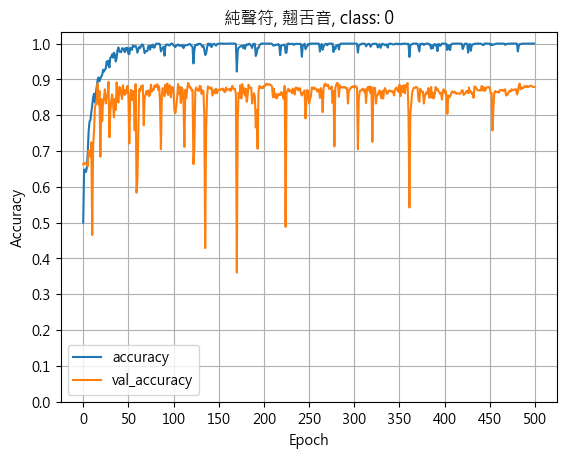

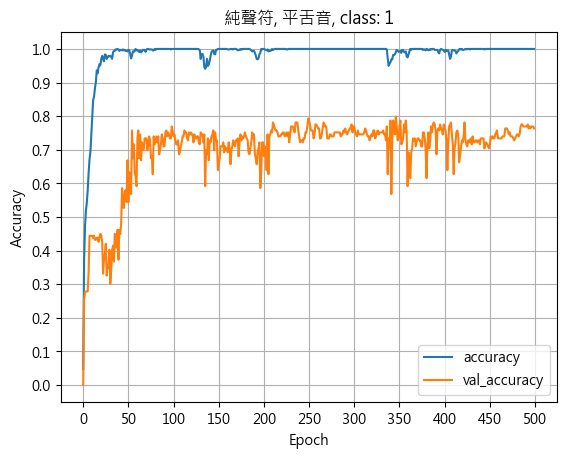

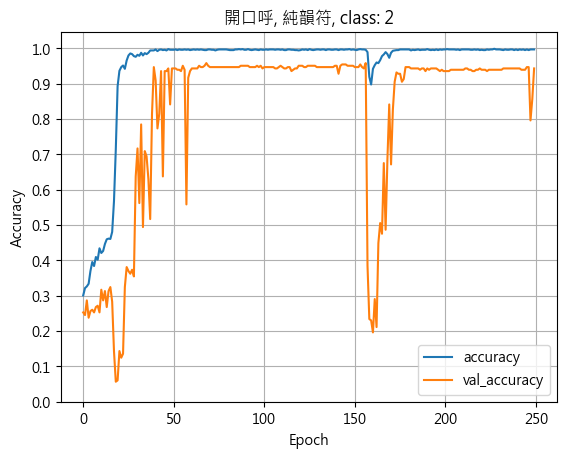

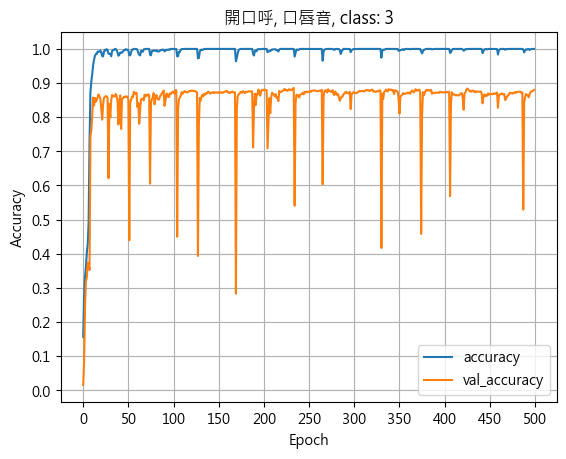

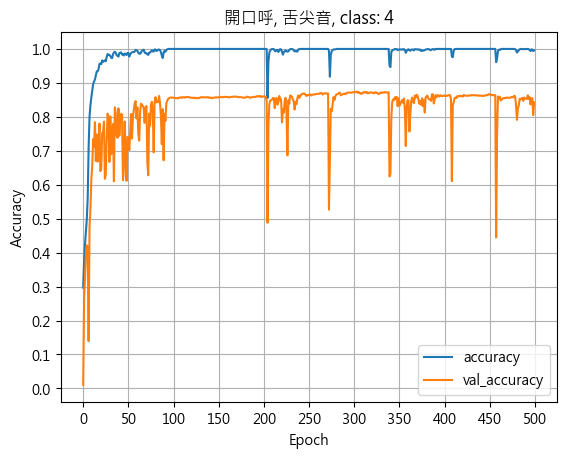

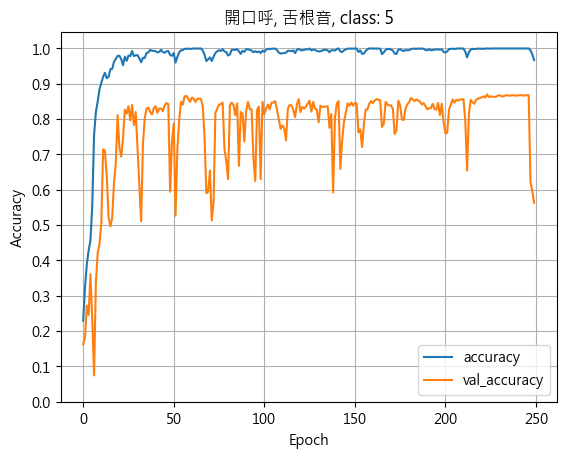

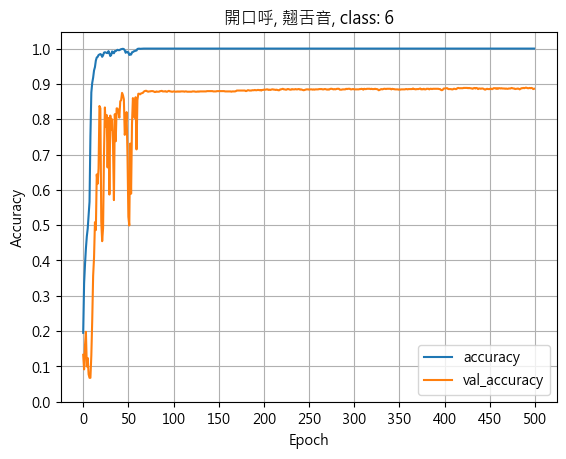

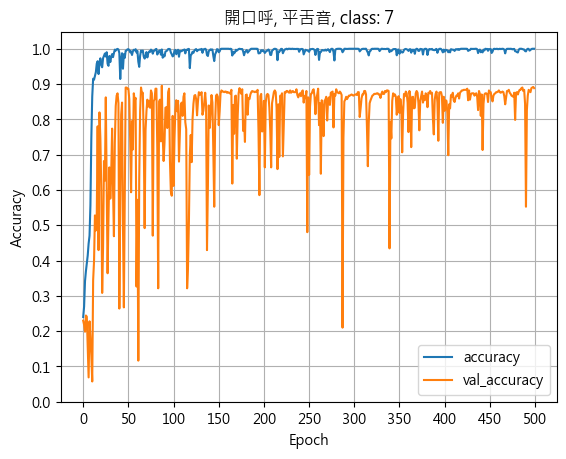

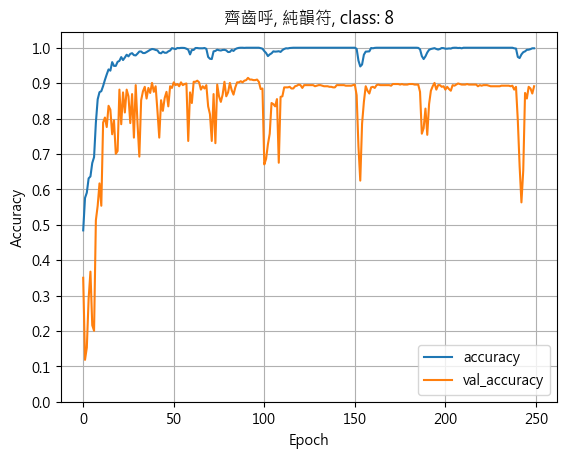

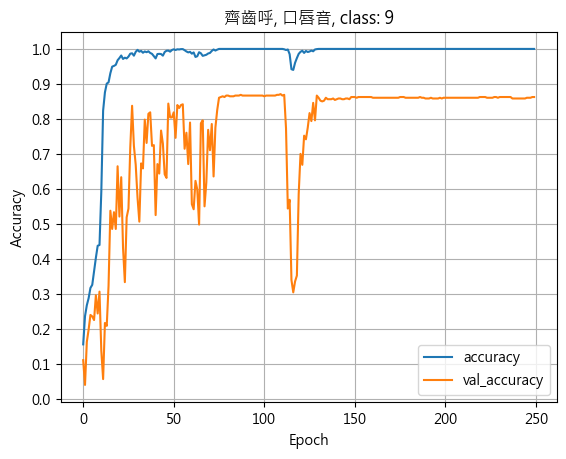

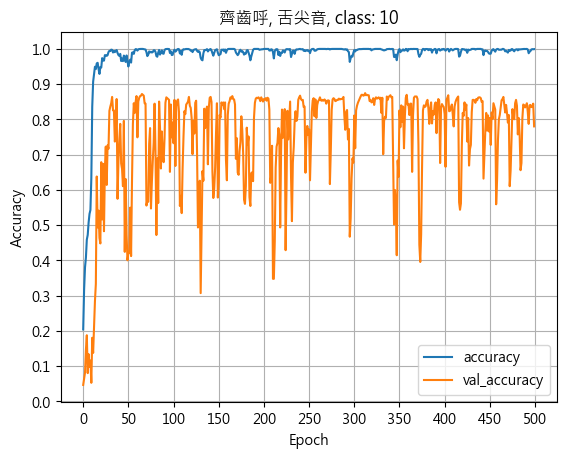

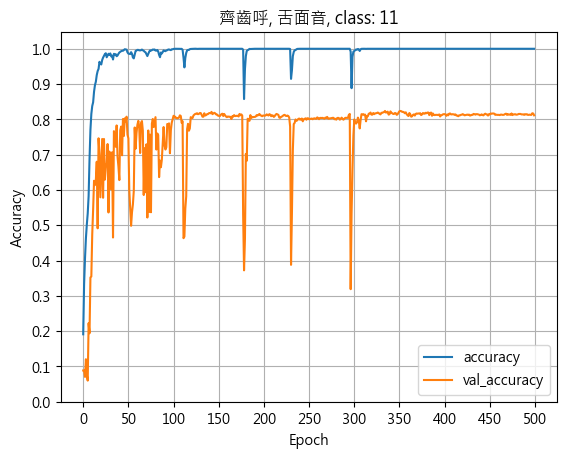

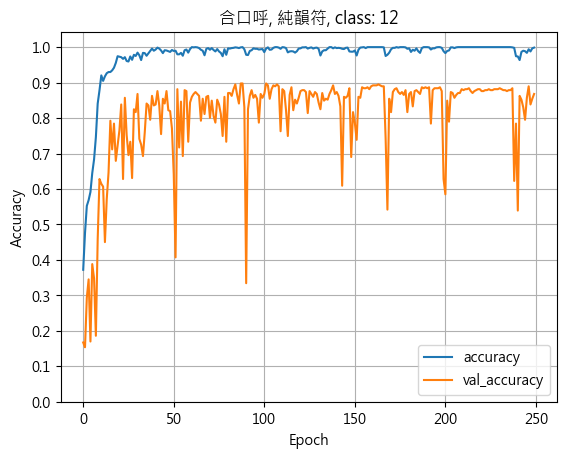

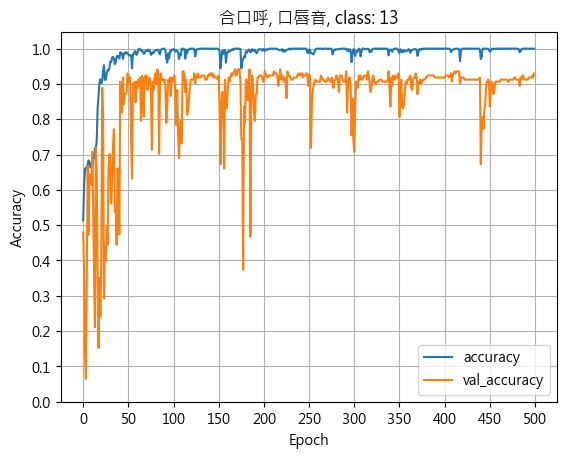

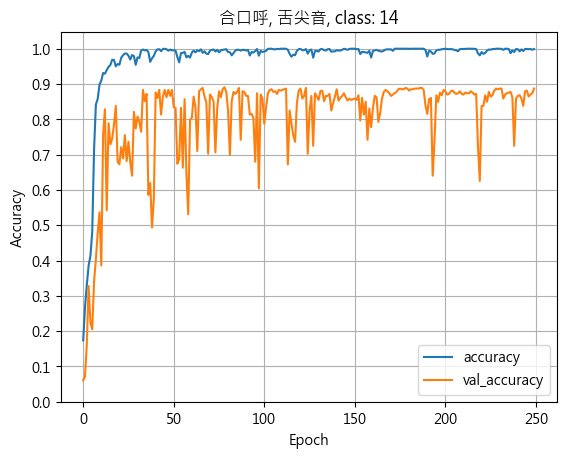

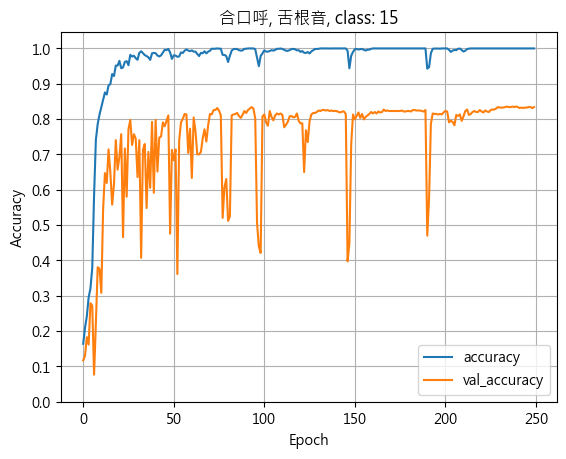

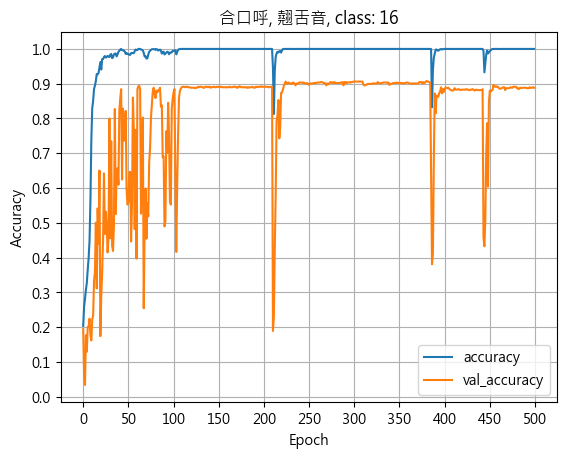

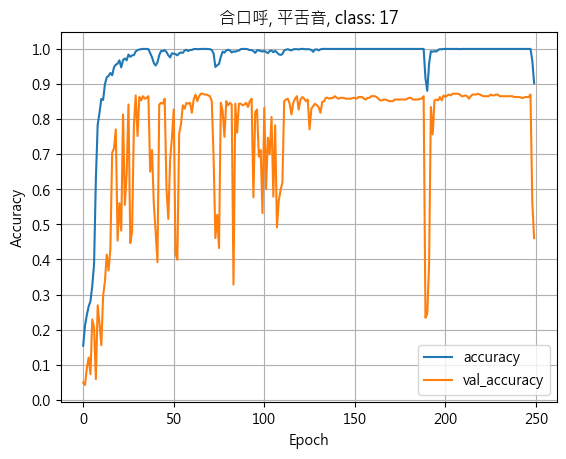

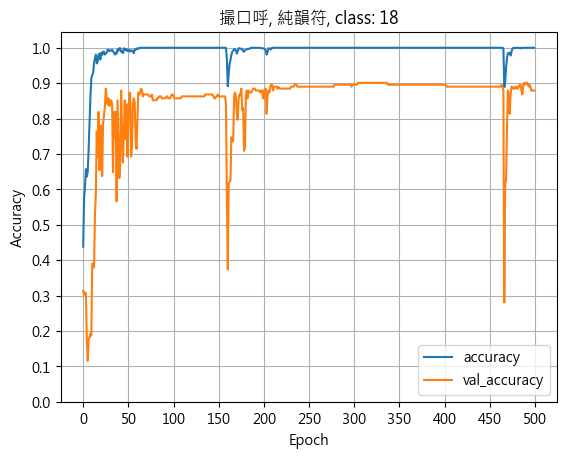

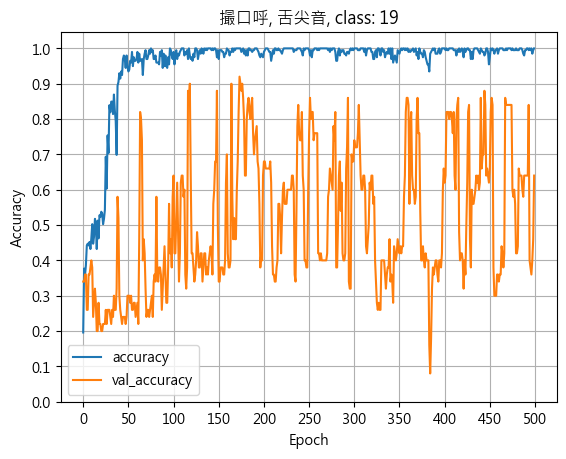

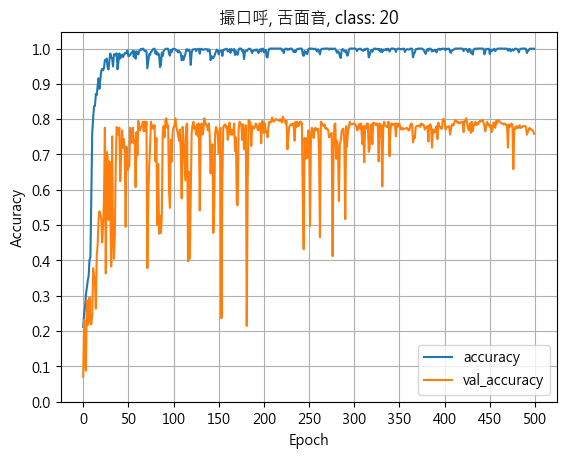

In [31]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

for class_label, model_train_info in enumerate(model_train_info_list):
    accuracies = model_train_info.history['accuracy']
    val_accuracies = model_train_info.history['val_accuracy']
    
    best_params = json.load(
        open(
            file=f"..\\..\\grid_search\\method2_with_fake_data\\layer2\\best_parameters_record\\best_parameters_class{class_label}.json",
            mode="r"
        )
    )
    
    epochs = best_params["epochs"]
    
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    plt.title(f"{hu_yin}, {she2_yin}, class: {class_label}")
    
    plt.plot(list(range(epochs)), accuracies, label="accuracy")
    plt.plot(list(range(epochs)), val_accuracies, label="val_accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(ticks = list(range(1, epochs + 1))) 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=list(range(0, epochs + 1, 50)))
    plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
    plt.show()

In [32]:
best_accuracy_list = list()

for class_label, model_train_info in enumerate(model_train_info_list):
    val_accuracies = model_train_info.history['val_accuracy']
    best_accuracy = max(val_accuracies)
    hu_yin = class_df.loc[class_df["class_label"] == class_label, "hu_yin"].values[0]
    she2_yin = class_df.loc[class_df["class_label"] == class_label, "she2_yin"].values[0]
    print(f"class: {class_label}, {hu_yin}, {she2_yin}, 最高準確率: {best_accuracy}")
    best_accuracy_list.append(best_accuracy)

class: 0, 純聲符, 翹舌音, 最高準確率: 0.8931419253349304
class: 1, 純聲符, 平舌音, 最高準確率: 0.7988165616989136
class: 2, 開口呼, 純韻符, 最高準確率: 0.9584905505180359
class: 3, 開口呼, 口唇音, 最高準確率: 0.885660707950592
class: 4, 開口呼, 舌尖音, 最高準確率: 0.8745692372322083
class: 5, 開口呼, 舌根音, 最高準確率: 0.8700000047683716
class: 6, 開口呼, 翹舌音, 最高準確率: 0.8894389271736145
class: 7, 開口呼, 平舌音, 最高準確率: 0.8950819969177246
class: 8, 齊齒呼, 純韻符, 最高準確率: 0.914826512336731
class: 9, 齊齒呼, 口唇音, 最高準確率: 0.8708333373069763
class: 10, 齊齒呼, 舌尖音, 最高準確率: 0.8745519518852234
class: 11, 齊齒呼, 舌面音, 最高準確率: 0.8236824870109558
class: 12, 合口呼, 純韻符, 最高準確率: 0.8975741267204285
class: 13, 合口呼, 口唇音, 最高準確率: 0.9415204524993896
class: 14, 合口呼, 舌尖音, 最高準確率: 0.8907721042633057
class: 15, 合口呼, 舌根音, 最高準確率: 0.8354253768920898
class: 16, 合口呼, 翹舌音, 最高準確率: 0.9074829816818237
class: 17, 合口呼, 平舌音, 最高準確率: 0.8723404407501221
class: 18, 撮口呼, 純韻符, 最高準確率: 0.901098906993866
class: 19, 撮口呼, 舌尖音, 最高準確率: 0.9200000166893005
class: 20, 撮口呼, 舌面音, 最高準確率: 0.8073170781135559


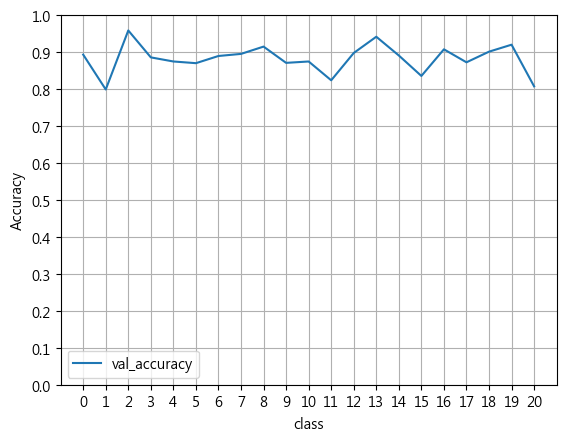

In [33]:
plt.plot(range(len(best_accuracy_list)), best_accuracy_list, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks=list(range(1, len(best_accuracy_list) + 1))) 
plt.xlabel("class")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(best_accuracy_list)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [34]:
model_dir_path = ".\\method2_layer2_models"
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)
    
for i, model in enumerate(model_list):
    model.save(filepath=f"{model_dir_path}\\class_{i}_model.h5")